In [1]:
import os
import time

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors

import cartopy.crs as ccrs
import cartopy.feature as cf

from tqdm import tqdm

# Data

In [2]:
DS = xr.open_dataset("./GFED4_FBA.nc")
y = DS.data_vars['Fraction_of_BurntArea'].sel(time=slice('2001-01-01','2015-12-31'))

DS_ = xr.open_dataset("./JSB4_DL_fire_025nc")
yhat_jsbdl = DS_.data_vars['burned_fract_box'].sel(time=slice('2001-01-01','2015-12-31'))

DS_ = xr.open_dataset("./JSB4_simple_025.nc")
yhat_simple = DS_.data_vars['burned_fract_box'].sel(time=slice('2001-01-01','2015-12-31'))

In [3]:
y_mean = np.nanmean(y, axis=0)
yhat_jsbdl_mean = np.nanmean(yhat_jsbdl, axis=0)
yhat_simple_mean = np.nanmean(yhat_simple, axis=0)

print(y_mean.shape)
print(yhat_jsbdl_mean.shape)
print(yhat_simple_mean.shape)

In [ ]:
y_mean[y_mean == 0.] = np.NaN
yhat_jsbdl_mean[yhat_jsbdl_mean == 0.] = np.NaN
yhat_simple_mean[yhat_simple_mean == 0.] = np.NaN

# plotting

In [ ]:
def ruota_antiorario(matrix):
    ruota=list(zip(*reversed(matrix)))
    return[list(elemento) for elemento in ruota]
def ruota_orario(matrix):
    ruota=list(zip(*reversed(matrix)))
    return[list(elemento)[::-1] for elemento in ruota][::-1]

In [ ]:
coord = np.meshgrid(DS.lat.values, DS.lon.values)
coord_ = np.meshgrid(DS_.lat.values, DS_.lon.values)

/Net/Groups/BGI/people/rackhun/program/miniconda3/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/Net/Groups/BGI/people/rackhun/program/miniconda3/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/Net/Groups/BGI/people/rackhun/program/miniconda3/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDepre

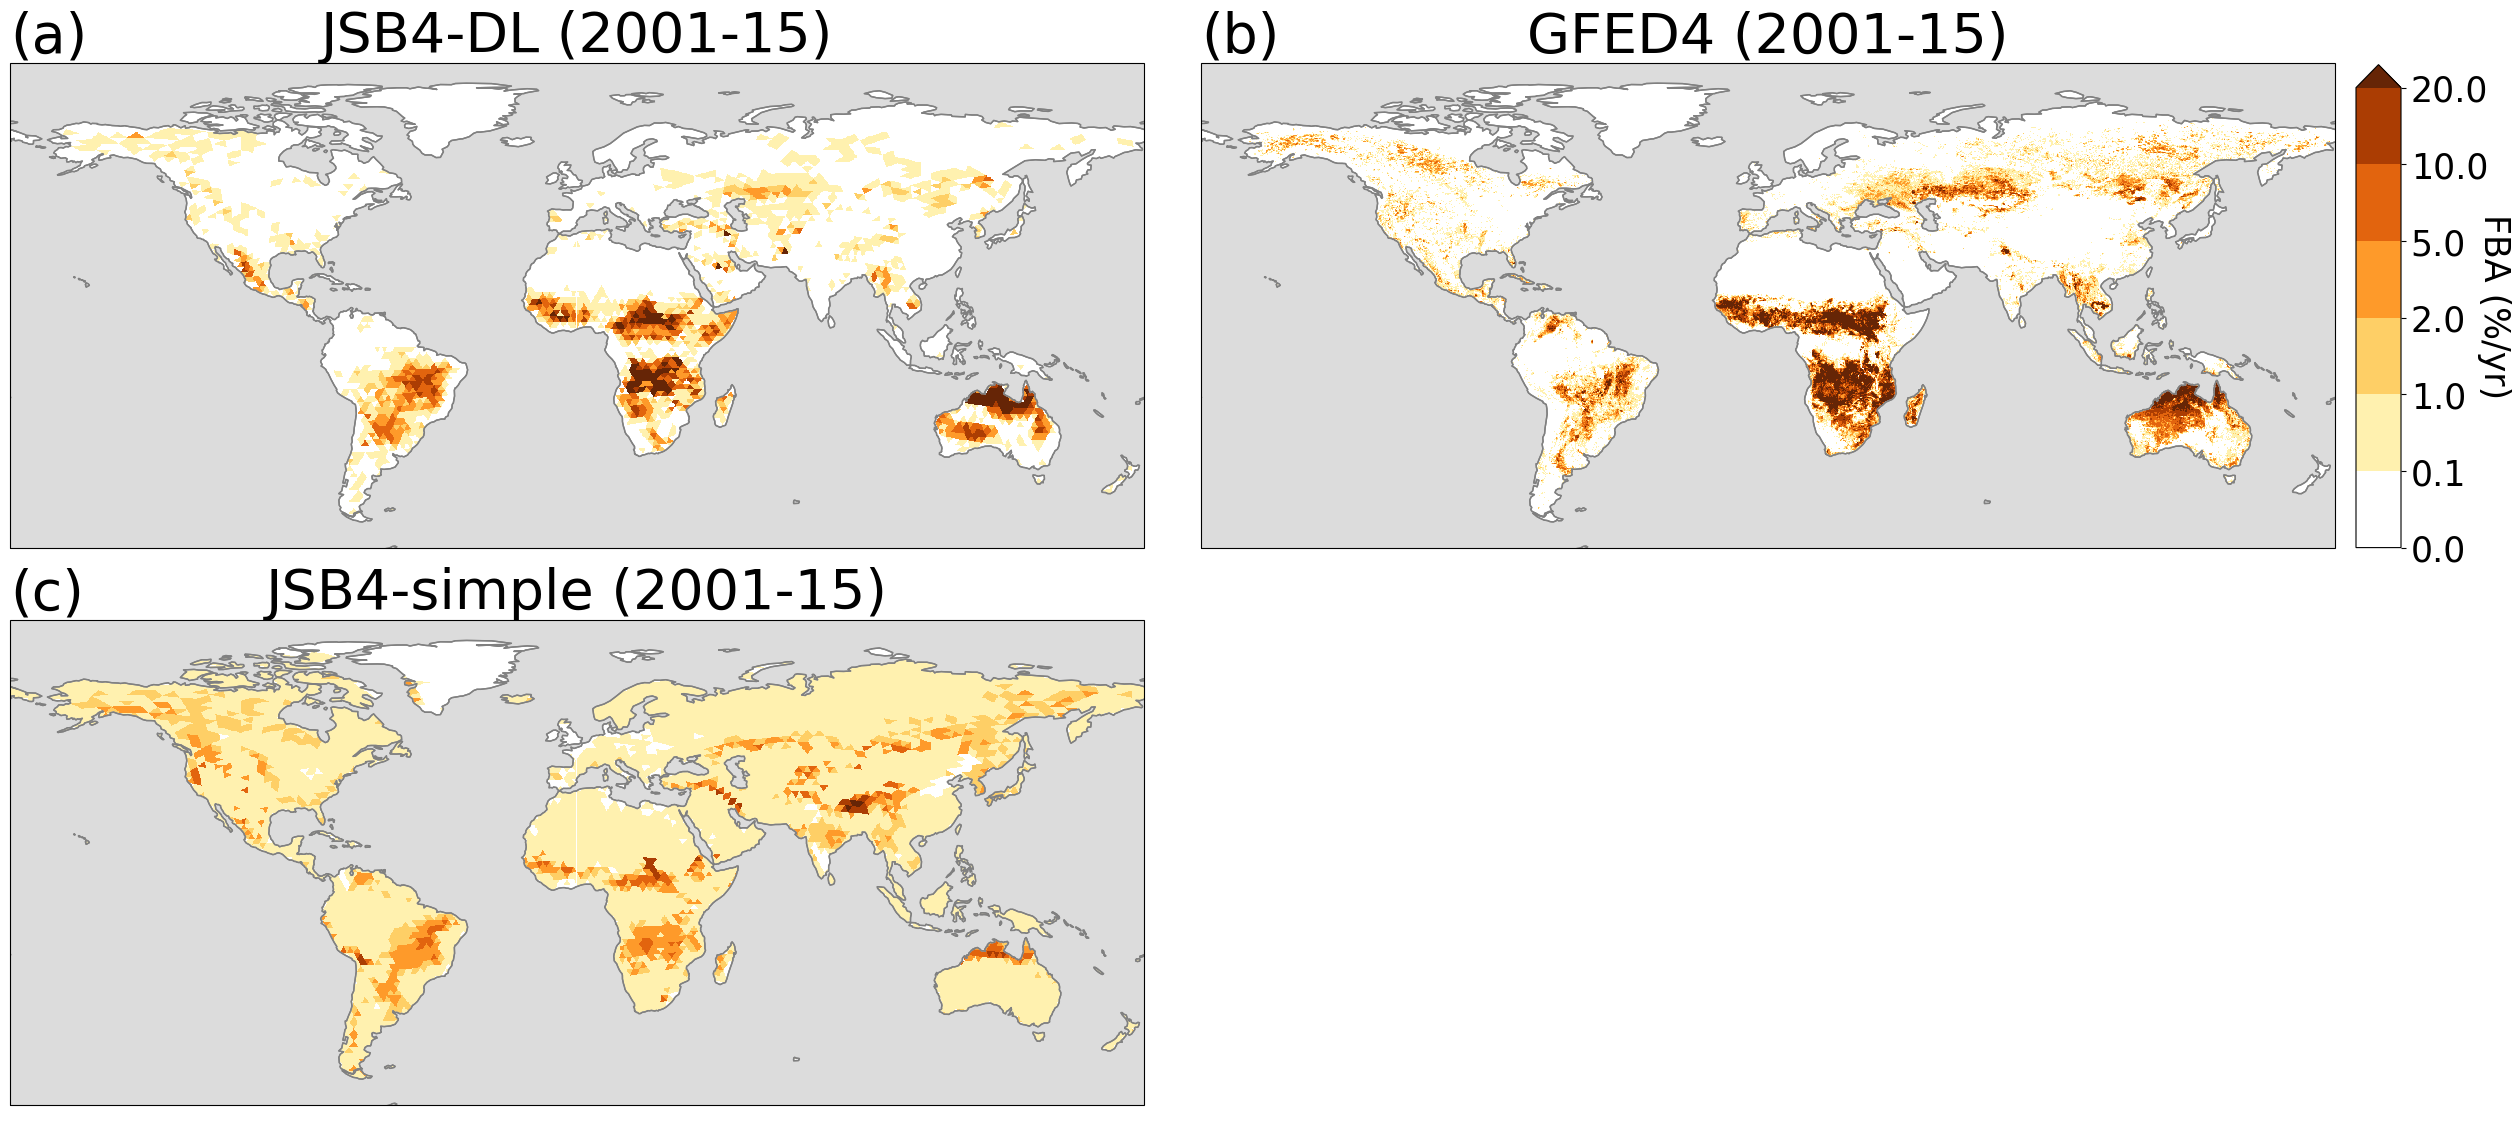

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(30,14), frameon=False, 
    subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=0))
)

fig.subplots_adjust(wspace=0.05, hspace=0.07)

for i, (m, c, title1, title2) in enumerate(
    zip([yhat_jsbdl_mean*365*100, y_mean*365*100, yhat_simple_mean*365*100],
        [coord_, coord, coord_],
        ['(a)', '(b)', '(c)'],
        ['JSB4-DL-fire (2001-15)', 'GFED4 (2001-15)', 'JSB4-simple (2001-15)']
    )):

    x = m.copy()
    x[x<0] = 0
    x[x>20] = 20+1.

    axs[i//2, i%2].set_extent([-10,180,-10,90])
    axs[i//2, i%2].add_feature(cf.OCEAN, color='gainsboro')
    axs[i//2, i%2].add_feature(cf.COASTLINE, linewidth=1., color='gray')

    cmap = plt.cm.YlOrBr
    bounds = [0, 0.1, 1, 2, 5, 10, 20]
    norm = colors.BoundaryNorm(bounds, cmap.N, extend='max')
    
    cmap_list = ['white'] + [cmap(i) for i in range(cmap.N)]
    cmap = colors.LinearSegmentedColormap.from_list('my_palette', cmap_list, cmap.N)

    cs = axs[i//2, i%2].pcolormesh(c[1], c[0], 
        np.fliplr(ruota_antiorario(x)), 
        cmap=cmap,
        norm=norm,
        transform=ccrs.PlateCarree(),
        vmin=0, vmax=20,
    )

    axs[i//2, i%2].set_title(f'{title1}', size=40, loc='left')
    axs[i//2, i%2].set_title(f'{title2}', size=40, loc='center')
    axs[i//2, i%2].add_feature(cf.OCEAN, zorder=1, color='gainsboro')
    axs[i//2, i%2].add_feature(cf.COASTLINE, linewidth=1., color='gray')

cbar_ax = fig.add_axes([0.907, 0.521, 0.015, 0.345])
cbar = plt.colorbar(cs, 
    cax=cbar_ax, 
    cmap=cmap, 
    ticks=bounds,
    norm=norm, 
    extend='max',
)
cbar.ax.tick_params(labelsize=25)
cbar.set_label('FBA (%/yr)', fontsize=25, rotation=270, va='center')
axs[1,1].set_axis_off()
plt.show()